In [1]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import random 

from torch.utils.data import Dataset

In [2]:
def pair_color_depth_files(root_dir):
    color_dict = {}
    depth_dict = {}

    for directory, _, files in os.walk(root_dir):
        # e.g. directory = "/path/to/nyu2_train/basement_0001a_out"
        subdir_name = os.path.basename(directory)  # "basement_0001a_out"

        for f in files:
            full_path = os.path.join(directory, f)
            base_no_ext = os.path.splitext(f)[0]  # e.g. "1" for "1.jpg"

            # Combine them so that "basement_0001a_out" + "_" + "1"
            prefix = f"{subdir_name}_{base_no_ext}"

            if f.endswith("_colors.png"):
                color_dict[prefix] = full_path
            elif f.endswith("_depth.png"):
                depth_dict[prefix] = full_path
            elif f.endswith(".jpg"):
                color_dict[prefix] = full_path
            elif f.endswith(".png"):
                depth_dict[prefix] = full_path

    pairs = []
    for prefix, cpath in color_dict.items():
        if prefix in depth_dict:
            pairs.append((cpath, depth_dict[prefix]))

    return pairs

In [3]:
class NYUDepthDataset(Dataset):
    def __init__(self, root_dir, img_size=(480, 640), transform=None, apply_mask=True):
        """
        Args:
            root_dir: Path to the folder containing color/depth pairs (e.g. nyu2_train or nyu2_test).
            img_size: Desired (height, width) for resizing.
            transform: Optional transforms (e.g., Torchvision transforms) after resizing/normalizing.
            apply_mask: Whether to create and apply a random mask.
        """
        super().__init__()
        self.root_dir = root_dir
        self.img_size = img_size
        self.transform = transform
        self.apply_mask = apply_mask

        # Create a list of (color_path, depth_path) pairs
        self.samples = pair_color_depth_files(root_dir)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        color_path, depth_path = self.samples[idx]

        # print("color_depth:", color_path)
        # print("depth_path:",  depth_path)

        # ----- Load color image ----- 
        img = cv2.imread(color_path)
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize to (width, height) for OpenCV
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]))
        # Normalize to [0, 1]
        img = img.astype(np.float32) / 255.0

        # ----- Load depth image -----
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        depth = cv2.resize(depth, (self.img_size[1], self.img_size[0]))
        depth = depth.astype(np.float32) / 255.0  # Adjust as needed

        # If apply_mask is True, create a random mask and apply it
        if self.apply_mask:
            mask_2d = self.create_random_mask(self.img_size)
            # Expand mask to 3 channels for the color image
            mask_3d = np.stack([mask_2d]*3, axis=-1)

            # Make a copy for the masked versions
            masked_img = img.copy()
            masked_depth = depth.copy()

            # Where mask == 0, set color to 1.0 (white) and depth to 0
            masked_img[mask_3d == 0] = 1.0
            masked_depth[mask_2d == 0] = 0.0
        else:
            # If no mask, just pass the original images
            mask_2d = np.ones((self.img_size[0], self.img_size[1]), dtype=np.float32) * 255
            masked_img = img
            masked_depth = depth

        # ----- Convert to Torch Tensors -----
        # Color images: (H, W, C) -> (C, H, W)
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)
        masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1)

        # Depth images: (H, W) -> (1, H, W)
        depth_tensor = torch.from_numpy(depth).unsqueeze(0)
        masked_depth_tensor = torch.from_numpy(masked_depth).unsqueeze(0)

        # Mask: (H, W) -> (1, H, W), normalized to [0, 1]
        mask_tensor = torch.from_numpy(mask_2d.astype(np.float32) / 255.0).unsqueeze(0)

        # Optionally apply user-supplied transforms (e.g. augmentations)
        if self.transform is not None:
            # Typically you might do: (But be careful with how transforms are applied to multi-channel data)
            img_tensor = self.transform(img_tensor)
            masked_img_tensor = self.transform(masked_img_tensor)
            # For depth or mask, you might have a separate transform pipeline or skip

        return {
            "image": img_tensor,          # Original color image
            "masked_image": masked_img_tensor,
            "depth": depth_tensor,        # Original depth map
            "masked_depth": masked_depth_tensor,
            "mask": mask_tensor
        }

    def create_random_mask(self, size):
        """
        Create a random mask of shape (H, W) using random lines.
        White=255 => unmasked, Black=0 => masked.
        """
        H, W = size
        mask = np.full((H, W), 255, np.uint8)

        # Draw a random number of lines
        num_lines = np.random.randint(1, 10)
        for _ in range(num_lines):
            x1, x2 = np.random.randint(0, W, size=2)
            y1, y2 = np.random.randint(0, H, size=2)
            thickness = np.random.randint(1, 3)
            cv2.line(mask, (x1, y1), (x2, y2), 0, thickness)
        return mask


In [4]:
from torch.utils.data import DataLoader

# Example: Using the train folder
train_root = "nyu_data/data/nyu2_train"
train_dataset = NYUDepthDataset(root_dir=train_root, img_size=(480, 640), apply_mask=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Example: Using the test folder
test_root = "nyu_data/data/nyu2_test"
test_dataset = NYUDepthDataset(root_dir=test_root, img_size=(480, 640), apply_mask=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Get one batch
sample_batch = next(iter(train_loader))
# print("Keys in the batch:", sample_batch.keys())
# print("image shape:", sample_batch["image"].shape)               # torch.Size([4, 3, 480, 640])
# print("masked_image shape:", sample_batch["masked_image"].shape) # torch.Size([4, 3, 480, 640])
# print("depth shape:", sample_batch["depth"].shape)               # torch.Size([4, 1, 480, 640])
# print("masked_depth shape:", sample_batch["masked_depth"].shape) # torch.Size([4, 1, 480, 640])
# print("mask shape:", sample_batch["mask"].shape)                 # torch.Size([4, 1, 480, 640])

# sample_batch = next(iter(test_loader))
# print("Keys in the batch:", sample_batch.keys())
# print("image shape:", sample_batch["image"].shape)
# print("masked_image shape:", sample_batch["masked_image"].shape)
# print("depth shape:", sample_batch["depth"].shape)
# print("masked_depth shape:", sample_batch["masked_depth"].shape)
# print("mask shape:", sample_batch["mask"].shape)

In [ ]:
def show_sample(sample_dict, idx=0):
    """
    sample_dict is the dictionary returned by the DataLoader:
      {
        "image": (B, 3, H, W),
        "masked_image": (B, 3, H, W),
        "depth": (B, 1, H, W),
        "masked_depth": (B, 1, H, W),
        "mask": (B, 1, H, W)
      }
    idx is which item in the batch to visualize.
    """
    # Convert Torch tensors -> NumPy, shape (H, W, C). Tensor, shape (C, H, W)
    img_np = sample_dict["image"][idx].permute(1, 2, 0).cpu().numpy()
    masked_img_np = sample_dict["masked_image"][idx].permute(1, 2, 0).cpu().numpy()
    depth_np = sample_dict["depth"][idx].squeeze(0).cpu().numpy()
    masked_depth_np = sample_dict["masked_depth"][idx].squeeze(0).cpu().numpy()
    mask_np = sample_dict["mask"][idx].squeeze(0).cpu().numpy()

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    axs[0, 0].imshow(img_np)
    axs[0, 0].set_title("Original Image")

    axs[0, 1].imshow(mask_np, cmap='gray')
    axs[0, 1].set_title("Random Mask")

    axs[0, 2].imshow(masked_img_np)
    axs[0, 2].set_title("Masked Image")

    axs[1, 0].imshow(depth_np, cmap='gray')
    axs[1, 0].set_title("Original Depth")

    axs[1, 1].imshow(masked_depth_np, cmap='gray')
    axs[1, 1].set_title("Masked Depth")

    axs[1, 2].axis('off')
    plt.tight_layout()
    plt.show()

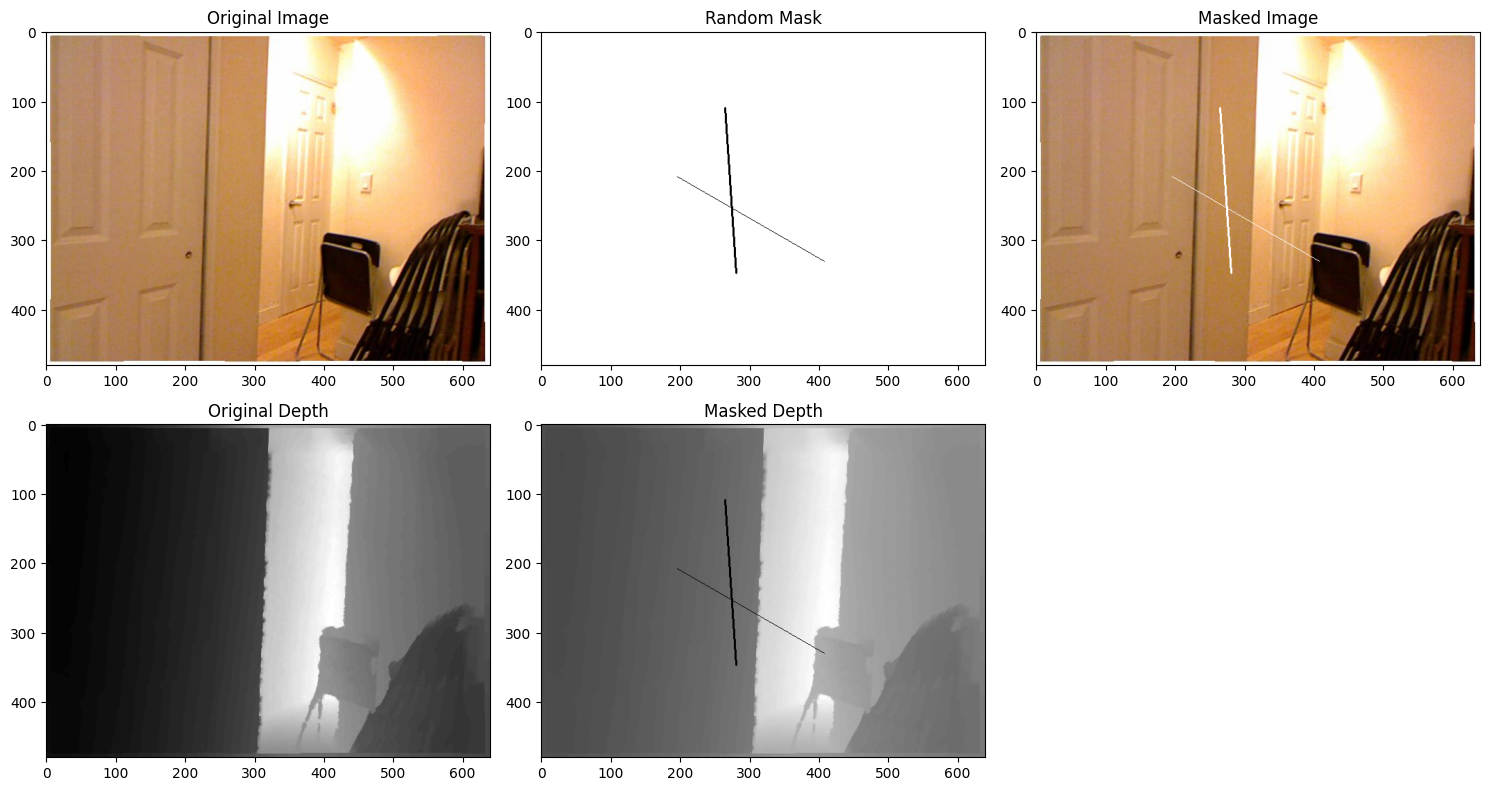

In [6]:
# Visualize first sample in the batch
show_sample(sample_batch, idx=0)